# Enron Email and Financial Dataset

> This notebook is part of a project from Udacity's Data Analyst Nanodegree

<ul>
<li><a href="#ols">StudentizedOLSClassifier</a></li>    
<li><a href="#outliers">Remove Outliers</a></li>
<li><a href="#transform">Data Transformation</a></li>    
<li><a href="#features">Create Features</a></li>
<li><a href="#features2">More Features</a></li>
<li><a href="#olsfinal">Final Model</a></li>
</ul>

In [1]:
import logging
logging.captureWarnings(True)
%matplotlib inline

In [2]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import Imputer, Normalizer
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLS
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import model_selection
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tester import dump_classifier_and_data, test_classifier
from testerFast import  test_classifier_fast
from feature_format import featureFormat, targetFeatureSplit
from sklearn.svm import LinearSVC
from scipy.stats import skew
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as sk_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SelectFpr
from sklearn.base import ClassifierMixin


SEED = 5678
np.random.seed(SEED)

<a id='ols'></a>
# StudentizedOLSClassifier
> This is a custom classifier created using Scikit Learn's project template for custom estimators.
> It uses statsmodels OLS for the initial fit. Predict then uses the same OLS model to make a 
> prediction. The median of the predictions is subtracted from the prediction to create an estimated 
> residual. The estimated residual is then divided by the standard deviation of the residuals from the fit
> to create an estimated studentized residual. These studentized residuals are then tested against the
> hyperparameter "threshold" to determine the label. All  values greater than or equal to the threshold are 
> labeled True, and values less than the threshold are labeled False.

In [3]:

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
import pandas as pd
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLS

class StudentizedOLSClassifier(BaseEstimator, ClassifierMixin ):
    
    def __init__(self, threshold = 'threshold'):
        
        #decision threshold of studentized residuals
        self.threshold = threshold    
        np.random.seed(SEED)
        
    def fit(self, X, y):
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y) 
        
        #convert to df
        self.X_ = pd.DataFrame(X)
        self.y_ = pd.DataFrame(y)         
        
        #Fit OLS model
        self.ols_mod = OLS(endog = self.y_, exog = self.X_)
        self.ols_result = self.ols_mod.fit()
        
        # Return the classifier
        return self

    def predict(self, X):
        
        # Check if fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        X_n = pd.DataFrame(X)
        
        #OLS prediction       
        prediction = self.ols_result.predict(X_n)        
        
        #calculate outlier and influence measures for OLS result
        inf = OLSInfluence(self.ols_result)
        
        #Staandard Deviation of studentized residuals
        std = inf.resid_std
        
        """
        Subtract the median of the predictions from the predictions to create an estimated residual.
        Then divide the estiamted residual by the by the estimated standard deviation, the
        standard deviation of the residuals from training, to create an estimated studentized residual.
           
        """ 
        # estimated residual
        estimated_residual = prediction - np.nanmedian(prediction)
        
        #estiamted studentized residual
        stud_res = estimated_residual/np.nanmean(std)    #estimate using mean
        #stud_res = prediction/np.nanmedian(std)         #estimate using median
        
        #create predictions based on the threshold
        self.preds = []        
        for res in stud_res:
            if res >= self.threshold:    
                self.preds.append(True)
            else:
                self.preds.append(False)
                
        return self.preds

# Functions

In [4]:
# prepares data for tester returns list and dict 
def tester_prep(dfn):
    features_list = dfn.columns.values
    data_dict = dfn.to_dict('index')
    return features_list, data_dict

# returns basic metrics for classifiers
def classification_metrics(y_val, preds):
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    total_val = len(y_val)
    all_y = len(y_val[y_val == True])
    per_tp = round(tp/all_y, 3) *100
    precision = 1.0*tp/(tp+fp)
    recall = 1.0*tp/(tp+fn)
    print(classification_report(y_val, preds))
    print('\nTrue Positive:  {}\nFalse Positive: {}\nTrue Negative:  {}\nFalse Negative: {}\n\nTotal: {}\nPercent True Positive: {}%'
          .format(tp, fp, tn, fn, total_val, per_tp))
    print('\nprecision: {}\nrecall: {}'.format(precision, recall))

# checks for skew in numeric columns
def skew_check(features):
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics2 = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes: 
            numerics2.append(i)

    skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    print(skews)
    #return skew_features
    
# Functions to plot feature importance
def plot_fi(fi, titl):
    return fi.plot('cols', 'imp', 'barh', figsize = (12,12), legend = False).set_title(titl, fontdict = {'fontsize' : 16})

# returns df of feature inportance
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=True)

#fits model to kfolds and returns column with predictions
def fit_folds(model, X_train, y_train,  n_folds):
    
    new_col = np.zeros((X_train.shape[0], 1))
    kfold = KFold( n_splits = n_folds, shuffle=True, random_state=SEED) 
        
    for train_index, test_index in kfold.split(X_train):  
        Xt, Xv = X_train.iloc[train_index], X_train.iloc[test_index]
        yt, yv = y_train.iloc[train_index], y_train.iloc[test_index]
        model.fit(Xt, yt)
        pred = np.column_stack([model.predict(Xv)])        
        new_col[test_index] = pred
                        
    return(new_col)

# Task 1: Select what features you'll use.

In [5]:

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
#        'exercised_stock_options', 'bonus', 'restricted_stock',
#        'shared_receipt_with_poi', 'restricted_stock_deferred',
#        'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
#        'other', 'from_this_person_to_poi', 'director_fees',
#        'deferred_income', 'long_term_incentive', 'from_poi_to_this_person',
#        'QDA', 'KNN', 'DTC', 'GNB', 'ABC', 'MLP'] 

# #removed features
# drop_these =  {'email_address','deferral_payments','restricted_stock_deferred', 'loan_advances'}

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
len(data_dict)

146

In [6]:
df = pd.DataFrame.from_dict(data_dict, orient = 'index')
raw_df = df.copy()
df.shape

(146, 21)

In [7]:
df.drop(['email_address'], axis = 1, inplace = True)

## Impute missing data
> This section caused a data leak so most of it was commented out

In [8]:
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [9]:
# not_cols =[ 'to_messages', 'from_messages', 'from_this_person_to_poi',  
#              'from_poi_to_this_person', 'salary',  'deferral_payments', 'total_payments',
#            'exercised_stock_options', 'bonus', 'restricted_stock',
#            'shared_receipt_with_poi', 'restricted_stock_deferred',
#            'total_stock_value', 'expenses', 'loan_advances', 
#            'other', 'director_fees', 'deferred_income', 'long_term_incentive']

# poi_cols =[ 'to_messages', 'from_messages', 'from_this_person_to_poi',  
#              'from_poi_to_this_person', 'salary',  'deferral_payments', 'total_payments',
#                'exercised_stock_options', 'bonus', 'restricted_stock',
#                'shared_receipt_with_poi', 
#                'total_stock_value', 'expenses', 'loan_advances', 
#                'other',  'deferred_income', 'long_term_incentive']

# # no values in poi data
# empty_cols = ['director_fees','restricted_stock_deferred']

In [10]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,56301.0,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,11200.0,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,129142.0,NaN,NaN,69.0,NaN,False,NaN,-201641.0,NaN,NaN


In [11]:
# imputer_poi = Imputer(missing_values='NaN', strategy = 'mean', axis=0)
# imputer_not = Imputer(missing_values='NaN', strategy = 'mean', axis=0)

In [12]:
# poi_df = df[df['poi'] == True]
# not_df = df[df['poi'] == False]

# not_df.loc[: , not_cols] = imputer_not.fit_transform(not_df.loc[: , not_cols])
# poi_df.loc[: , poi_cols] = imputer_poi.fit_transform(poi_df.loc[: , poi_cols])

In [13]:
# poi_df[empty_cols] = poi_df[empty_cols].fillna(value = 0, axis = 0)

In [14]:
# not_df.head()

In [15]:
# df = pd.concat([poi_df, not_df],axis = 0)
# df.shape

In [16]:
# df.head()

In [17]:
df = df.fillna(value = 0, axis = 0)

In [18]:
y = df['poi'].copy()
df.drop(['poi'], axis = 1, inplace = True)
print(y.shape, df.shape)

((146L,), (146, 19))


In [19]:
df.isnull().values.any()

False

<a id='outliers'></a>
# Task 2: Remove outliers

In [20]:
ols_mod = OLS(endog = y.values, exog = df)
ols_result = ols_mod.fit()

In [21]:
out_test = ols_result.outlier_test()['bonf(p)']

In [22]:
outliers = list(out_test[out_test<1e-3].index) 

outliers

['BHATNAGAR SANJAY']

In [23]:
inf = OLSInfluence(ols_result)
stud = inf.resid_studentized_internal
less_outliers = list(stud[stud < -1 ].index)  
more_outliers = list(stud[stud > 1 ].index) 
print(less_outliers, more_outliers)

(['BECK SALLY W', 'BHATNAGAR SANJAY', 'BLACHMAN JEREMY M', 'BUY RICHARD B', 'DIETRICH JANET R', 'LAVORATO JOHN J', 'LEFF DANIEL P', 'MCCONNELL MICHAEL S', 'REDMOND BRIAN L', 'SHARP VICTORIA T', 'SUNDE MARTIN', 'TOTAL', 'WHALLEY LAWRENCE G'], ['BELDEN TIMOTHY N', 'BOWEN JR RAYMOND M', 'CALGER CHRISTOPHER F', 'CAUSEY RICHARD A', 'COLWELL WESLEY', 'DELAINEY DAVID W', 'FASTOW ANDREW S', 'GLISAN JR BEN F', 'HIRKO JOSEPH', 'KAMINSKI WINCENTY J', 'KOENIG MARK E', 'KOPPER MICHAEL J', 'LAY KENNETH L', 'RIEKER PAULA H', 'SHELBY REX', 'SKILLING JEFFREY K', 'YEAGER F SCOTT'])


In [24]:
inf = OLSInfluence(ols_result)
stud = inf.resid_studentized_internal
less_outliers = list(stud[stud < -1 ].index) 
more_outliers = list(stud[stud > 1 ].index)

In [25]:
print(len(y.loc[more_outliers]))
print(y.loc[more_outliers])

17
BELDEN TIMOTHY N         True
BOWEN JR RAYMOND M       True
CALGER CHRISTOPHER F     True
CAUSEY RICHARD A         True
COLWELL WESLEY           True
DELAINEY DAVID W         True
FASTOW ANDREW S          True
GLISAN JR BEN F          True
HIRKO JOSEPH             True
KAMINSKI WINCENTY J     False
KOENIG MARK E            True
KOPPER MICHAEL J         True
LAY KENNETH L            True
RIEKER PAULA H           True
SHELBY REX               True
SKILLING JEFFREY K       True
YEAGER F SCOTT           True
Name: poi, dtype: bool


In [26]:
print(len(raw_df.loc[(raw_df['poi'] == True)]))

18


In [27]:
print(len(y.loc[less_outliers]))
print(y.loc[less_outliers])

13
BECK SALLY W           False
BHATNAGAR SANJAY       False
BLACHMAN JEREMY M      False
BUY RICHARD B          False
DIETRICH JANET R       False
LAVORATO JOHN J        False
LEFF DANIEL P          False
MCCONNELL MICHAEL S    False
REDMOND BRIAN L        False
SHARP VICTORIA T       False
SUNDE MARTIN           False
TOTAL                  False
WHALLEY LAWRENCE G     False
Name: poi, dtype: bool


In [28]:
drop_list = set(df.loc[less_outliers].index )
drop_list.update(df.loc[['TOTAL']].index)
drop_list.update(df.loc[['THE TRAVEL AGENCY IN THE PARK']].index)
drop_list.update(df.loc[['KAMINSKI WINCENTY J']].index)
#drop_list.update(df.loc[more_outliers].index)
print(drop_list)

set(['BLACHMAN JEREMY M', 'TOTAL', 'BECK SALLY W', 'BHATNAGAR SANJAY', 'BUY RICHARD B', 'SUNDE MARTIN', 'MCCONNELL MICHAEL S', 'DIETRICH JANET R', 'LEFF DANIEL P', 'REDMOND BRIAN L', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'KAMINSKI WINCENTY J', 'THE TRAVEL AGENCY IN THE PARK', 'SHARP VICTORIA T'])


In [29]:
df.drop(drop_list, axis = 0, inplace = True)

print(df.shape, y.shape)

((131, 19), (146L,))


In [30]:
y.drop(drop_list, axis = 0, inplace = True)
print(df.shape, y.shape)

((131, 19), (131L,))


In [31]:
y.value_counts()

False    113
True      18
Name: poi, dtype: int64

<a id='transform'></a>
# Data Transformations
> Standard scaler was originally used, later dropped and commented out

In [32]:
print(df.mean(axis=0), df.std(axis=0))

(salary                       1.776924e+05
to_messages                  9.958321e+02
deferral_payments            2.377393e+05
total_payments               2.126312e+06
exercised_stock_options      2.089678e+06
bonus                        6.068215e+05
restricted_stock             9.090039e+05
shared_receipt_with_poi      5.502443e+02
restricted_stock_deferred   -3.728330e+04
total_stock_value            2.960700e+06
expenses                     3.485377e+04
loan_advances                6.406489e+05
from_messages                1.995802e+02
other                        3.166352e+05
from_this_person_to_poi      1.671756e+01
director_fees                9.918336e+03
deferred_income             -2.075995e+05
long_term_incentive          3.080627e+05
from_poi_to_this_person      2.879389e+01
dtype: float64, salary                       2.016122e+05
to_messages                  2.110753e+03
deferral_payments            7.872105e+05
total_payments               9.171184e+06
exercised_stock_o

In [33]:
# norm = preprocessing.Normalizer()
# norm_df = norm.fit_transform(df)

# sc = preprocessing.StandardScaler()
# scaled_df = sc.fit_transform(df)

In [34]:
# col = df.columns.values
# df = pd.DataFrame(scaled_df, columns = col)

In [35]:
# print(df.mean(axis=0), df.std(axis=0))

In [36]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,0.0,2195.0,152.0,65.0,0.0,-3081055.0,304805.0,47.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,0.0,29.0,864523.0,0.0,0.0,-5104.0,0.0,39.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,11200.0,0.0,0.0,2660303.0,0.0,0.0,-1386055.0,1586055.0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,129142.0,0.0,0.0,69.0,0.0,0.0,-201641.0,0.0,0.0


## df_all

In [37]:
y.head()

ALLEN PHILLIP K       False
BADUM JAMES P         False
BANNANTINE JAMES M    False
BAXTER JOHN C         False
BAY FRANKLIN R        False
Name: poi, dtype: bool

y.reset_index(drop = True, inplace = True)

In [38]:
#alll data
df_all = pd.concat([y, df ], axis = 1)
df_all.shape

(131, 20)

In [39]:
df_all.tail()

,poi,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
WINOKUR JR. HERBERT S,False,0.0,0.0,0.0,84992.0,0.0,0.0,0.0,0.0,0.0,0.0,1413.0,0.0,0.0,0.0,0.0,108579.0,-25000.0,0.0,0.0
WODRASKA JOHN,False,0.0,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189583.0,0.0,0.0,0.0,0.0,0.0
WROBEL BRUCE,False,0.0,0.0,0.0,0.0,139130.0,0.0,0.0,0.0,0.0,139130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YEAGER F SCOTT,True,158403.0,0.0,0.0,360300.0,8308552.0,0.0,3576206.0,0.0,0.0,11884758.0,53947.0,0.0,0.0,147950.0,0.0,0.0,0.0,0.0,0.0
YEAP SOON,False,0.0,0.0,0.0,55097.0,192758.0,0.0,0.0,0.0,0.0,192758.0,55097.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='features'></a>
# Task 3: Create new feature(s) 

### MODELS as features
#### Test Several Models

QDA: 0.000000 (0.000000)
GPC: 0.000000 (0.000000)
KNN: 0.166667 (0.139443)
DTC: 0.233333 (0.200000)
GNB: 0.416667 (0.258199)
SVM: 0.000000 (0.000000)
ABC: 0.350000 (0.226078)
MLP: 0.050000 (0.100000)
RID: 0.283333 (0.163299)
log: 0.216667 (0.113039)


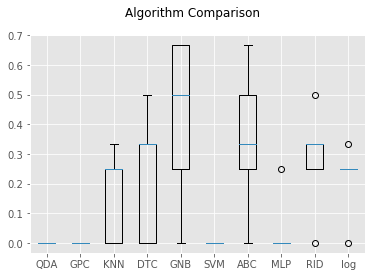

In [40]:
models = []
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('GPC', GaussianProcessClassifier(1.0 * RBF(1.0),random_state = SEED)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state = SEED)))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(random_state = SEED)))
models.append(('ABC', AdaBoostClassifier(random_state = SEED)))
models.append(('MLP', MLPClassifier( random_state = SEED, max_iter=1000)))
models.append(('RID', RidgeClassifier(random_state = SEED)))
models.append(('log', LogisticRegression(random_state = SEED)))

# test and plot all models in models list
def test_models(models, data, target):
    results = []
    names = []
    scoring = 'recall'

    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, data, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        #classification_metrics(y_val, rfc_pred)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()


#run test    
test_models(models, df, y)

In [41]:
smt = SMOTE(random_state = SEED)
#pipelines
lr_pipe =  Pipeline([('smt', smt),  ('lr', LogisticRegression(random_state = SEED))])
knn_pipe = Pipeline([('smt', smt),  ('knn', KNeighborsClassifier())])
gnb_pipe = Pipeline([('smt', smt),  ('gnb', GaussianNB())])
dtc_pipe = Pipeline([('smt', smt),  ('dtc', DecisionTreeClassifier(random_state = SEED))])
abc_pipe = Pipeline([('smt', smt),  ('abc', AdaBoostClassifier(random_state = SEED))])
mlp_pipe = Pipeline([('smt', smt),  ('lr', MLPClassifier( random_state = SEED, max_iter=1000))])
gpc_pipe = Pipeline([('smt', smt),  ('gpc', GaussianProcessClassifier(1.0 * RBF(1.0),random_state = SEED))])
qda_pipe = Pipeline([('smt', smt),  ('qda', QuadraticDiscriminantAnalysis())])
svc_pipe = Pipeline([('smt', smt),  ('svm', SVC(random_state = SEED))])
rid_pipe = Pipeline([('smt', smt),  ('rid', RidgeClassifier(random_state = SEED))])

QDA2: 0.000000 (0.000000)
GPC2: 0.000000 (0.000000)
KNN2: 0.616667 (0.187083)
DTC2: 0.383333 (0.233333)
GNB2: 0.616667 (0.187083)
SVM2: 1.000000 (0.000000)
ABC2: 0.466667 (0.281859)
MLP2: 0.050000 (0.100000)
LR2: 0.583333 (0.333333)
rid2: 0.600000 (0.161589)


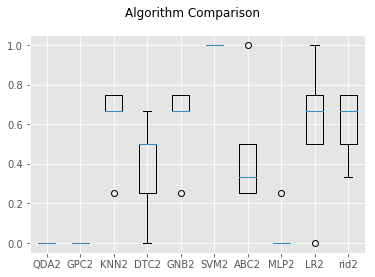

In [42]:

models = []
models.append(('QDA2', qda_pipe))
models.append(('GPC2', gpc_pipe))
models.append(('KNN2', knn_pipe))
models.append(('DTC2', dtc_pipe))
models.append(('GNB2', gnb_pipe))
models.append(('SVM2', svc_pipe))
models.append(('ABC2', abc_pipe))
models.append(('MLP2', mlp_pipe))
models.append(('LR2', lr_pipe))
models.append(('rid2', rid_pipe))



# test and plot all models in models list
def test_models(models, data, target):
    results = []
    names = []
    scoring = 'recall'

    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, data, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        #classification_metrics(y_val, rfc_pred)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()


#run test    
test_models(models, df, y)

In [43]:
### Test on fast Tester

In [44]:
df_all.columns.values

array(['poi', 'salary', 'to_messages', 'deferral_payments',
       'total_payments', 'exercised_stock_options', 'bonus',
       'restricted_stock', 'shared_receipt_with_poi',
       'restricted_stock_deferred', 'total_stock_value', 'expenses',
       'loan_advances', 'from_messages', 'other',
       'from_this_person_to_poi', 'director_fees', 'deferred_income',
       'long_term_incentive', 'from_poi_to_this_person'], dtype=object)

In [45]:
 # ols pipe smt
k = 19
ols_m = StudentizedOLSClassifier(1.04) 
#model = Pipeline([('fpr', SelectFpr()),  ('ols', ols_m)]) 
model = Pipeline([  ('kBest', SelectKBest( k = k)), ('ols', ols_m)])
#model = Pipeline([ ('smt', smt),  ('ols', ols_m)])
#model = ols_m
feat, dat = tester_prep(df_all)
test_classifier(model, dat, feat)


Pipeline(memory=None,
     steps=[('kBest', SelectKBest(k=19, score_func=<function f_classif at 0x000000000C648A58>)), ('ols', StudentizedOLSClassifier(threshold=1.04))])
	Accuracy: 0.86631	Precision: 0.56492	Recall: 0.57000	F1: 0.56745	F2: 0.56898
	Total predictions: 13000	True positives: 1140	False positives:  878	False negatives:  860	True negatives: 10122



In [46]:
# Fast TESTER with pipe
model = gnb_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('gnb', GaussianNB(priors=None))])
	Accuracy: 0.73077	Precision: 0.29167	Recall: 0.52500	F1: 0.37500	F2: 0.45259
	Total predictions:  260	True positives:   21	False positives:   51	False negatives:   19	True negatives:  169



In [47]:
# Fast TESTER with pipe
model = abc_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=5678))])
	Accuracy: 0.81923	Precision: 0.41463	Recall: 0.42500	F1: 0.41975	F2: 0.42289
	Total predictions:  260	True positives:   17	False positives:   24	False negatives:   23	True negatives:  196



In [48]:
# Fast TESTER with pipe
model = dtc_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('dtc', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None...      min_weight_fraction_leaf=0.0, presort=False, random_state=5678,
            splitter='best'))])
	Accuracy: 0.78462	Precision: 0.31818	Recall: 0.35000	F1: 0.33333	F2: 0.34314
	Total predictions:  260	True positives:   14	False positives:   30	False negatives:   26	True negatives:  190



In [49]:
# Fast TESTER with pipe
model = rid_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('rid', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=5678, solver='auto',
        tol=0.001))])
	Accuracy: 0.84615	Precision: 0.50000	Recall: 0.65000	F1: 0.56522	F2: 0.61321
	Total predictions:  260	True positives:   26	False positives:   26	False negatives:   14	True negatives:  194



In [50]:
# Fast TESTER with pipe
model = lr_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5678, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.66154	Precision: 0.22093	Recall: 0.47500	F1: 0.30159	F2: 0.38618
	Total predictions:  260	True positives:   19	False positives:   67	False negatives:   21	True negatives:  153



In [51]:
# Fast TESTER with pipe
model = gpc_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Got a divide by zero when trying out: Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('gpc', GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=1, n_restarts_optimizer=0,
             optimizer='fmin_l_bfgs_b', random_state=5678,
             warm_start=False))])
Precision or recall may be undefined due to a lack of true positive predicitons.


In [52]:
# Fast TESTER with pipe
model = knn_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.73846	Precision: 0.30556	Recall: 0.55000	F1: 0.39286	F2: 0.47414
	Total predictions:  260	True positives:   22	False positives:   50	False negatives:   18	True negatives:  170



In [53]:
# Fast TESTER NO pipe
model = RidgeClassifier(random_state = SEED)
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=5678, solver='auto',
        tol=0.001)
	Accuracy: 0.86923	Precision: 0.65000	Recall: 0.32500	F1: 0.43333	F2: 0.36111
	Total predictions:  260	True positives:   13	False positives:    7	False negatives:   27	True negatives:  213



# Grid Search

### Create a df with SMOTE for Grid Search

In [54]:
data_smote, y_smote =smt.fit_sample(df, y)
col = df.columns.values
df_smote = pd.DataFrame(data_smote, columns = col)
df_smote.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
0,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,0.0,2195.0,152.0,65.0,0.0,-3081055.0,304805.0,47.0
1,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,0.0,29.0,864523.0,0.0,0.0,-5104.0,0.0,39.0
3,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,11200.0,0.0,0.0,2660303.0,0.0,0.0,-1386055.0,1586055.0,0.0
4,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,129142.0,0.0,0.0,69.0,0.0,0.0,-201641.0,0.0,0.0


In [55]:
y_col = ['poi']
y_smote_df = pd.DataFrame(y_smote, columns = y_col)
y_smote_df.describe()

,poi
count,226
unique,2
top,True
freq,113


### AdaBoost

In [56]:
abc_cv = AdaBoostClassifier(random_state = SEED)

abc_grid = {'n_estimators' : [50, 75, 100, 150],
            'learning_rate': [0.1, 0.2, 0.5]            
            }

scoring = "f1"

gs_abc = GridSearchCV(abc_cv,
                     param_grid=abc_grid,
                     scoring=scoring, cv=5, n_jobs= 6, verbose = 1)

gs_abc.fit(df_smote, y_smote)
results = gs_abc.cv_results_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    6.8s finished


In [57]:
print('Best kfold score: {}'.format(gs_abc.best_score_))
print('Best kfold parameters: {}'.format(gs_abc.best_params_))

Best kfold score: 0.919923490194
Best kfold parameters: {'n_estimators': 150, 'learning_rate': 0.5}


In [58]:
# abc_m = AdaBoostClassifier(n_estimators = 150,
#                            learning_rate = 0.5,
#                            random_state = SEED)
abc_m = AdaBoostClassifier()

In [59]:
# Fast TESTER with pipe
model = Pipeline([('smt', smt),  ('abc', abc_m)])
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.81923	Precision: 0.41463	Recall: 0.42500	F1: 0.41975	F2: 0.42289
	Total predictions:  260	True positives:   17	False positives:   24	False negatives:   23	True negatives:  196



### Ridge

In [60]:
rid_cv = RidgeClassifier( random_state=SEED)

rid_grid = {'alpha' : [0.2, 0.5, 1, 1.5, 2, 3, 4, 10],
            'normalize' : [True, False]
           }

scoring = "f1"

gs_rid = GridSearchCV(rid_cv,
                     param_grid=rid_grid,
                     scoring=scoring, cv=5, n_jobs= 6, verbose = 1)

gs_rid.fit(df_smote, y_smote)
results = gs_rid.cv_results_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    4.7s finished


In [61]:
print('Best kfold score: {}'.format(gs_rid.best_score_))
print('Best kfold parameters: {}'.format(gs_rid.best_params_))

Best kfold score: 0.863264717199
Best kfold parameters: {'normalize': False, 'alpha': 0.2}


In [94]:
# Fast TESTER with pipe
rid_m = RidgeClassifier( alpha = 0.2, random_state=SEED)

model = Pipeline([('smt', smt),  ('rid', rid_m)])
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=7, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('rid', RidgeClassifier(alpha=0.2, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=5678, solver='auto',
        tol=0.001))])
	Accuracy: 0.83077	Precision: 0.46296	Recall: 0.62500	F1: 0.53191	F2: 0.58411
	Total predictions:  260	True positives:   25	False positives:   29	False negatives:   15	True negatives:  191



### Logistic Regression

In [63]:
log_reg_m = LogisticRegression(random_state = SEED)

log_grid = {#'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
            'C' : [0.5, 1, 1.5],
            'max_iter' : [ 1000, 1500, 2000, 3000],
            'solver' : ['newton-cg', 'liblinear'] # 'liblinear', , 'saga'
           }

scoring = "f1"

gs_lr = GridSearchCV(log_reg_m,
                     param_grid=log_grid,
                     scoring=scoring, cv=10, n_jobs= 6, verbose = 1)

gs_lr.fit(df_smote, y_smote)
results = gs_lr.cv_results_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   15.9s finished


In [64]:
print('Best kfold score: {}'.format(gs_lr.best_score_))
print('Best kfold parameters: {}'.format(gs_lr.best_params_))

Best kfold score: 0.904712527525
Best kfold parameters: {'C': 0.5, 'max_iter': 1000, 'solver': 'newton-cg'}


In [65]:
logR_m = LogisticRegression(C = 1.5,
                            max_iter = 1000,
                            solver = 'newton-cg',
                            random_state = SEED)
# Fast TESTER with pipe
model = Pipeline([('smt', smt),  ('log', logR_m)])
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('log', LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5678, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.83077	Precision: 0.46429	Recall: 0.65000	F1: 0.54167	F2: 0.60185
	Total predictions:  260	True positives:   26	False positives:   30	False negatives:   14	True negatives:  190



### GaussianProcessClassifier

In [66]:
gpc_m = GaussianProcessClassifier(1.0 * RBF(1.0),random_state = SEED)

gpc_grid = {'n_restarts_optimizer' : [0,1,3,7],
            'max_iter_predict' : [100, 300, 500],
            'warm_start' : [ True, False]
           }

scoring = "f1"

gs_gpc = GridSearchCV(gpc_m,
                     param_grid=gpc_grid,
                     scoring=scoring, cv=10, n_jobs= 6, verbose = 1)

gs_gpc.fit(df_smote, y_smote)
results = gs_gpc.cv_results_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   16.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:  3.2min finished


In [67]:
print('Best kfold score: {}'.format(gs_gpc.best_score_))
print('Best kfold parameters: {}'.format(gs_gpc.best_params_))

Best kfold score: 0.853852860315
Best kfold parameters: {'warm_start': True, 'max_iter_predict': 100, 'n_restarts_optimizer': 7}


In [68]:
gpc_m = GaussianProcessClassifier(1.0 * RBF(1.0),
                                  warm_start = True,                                  
                                  random_state = SEED)

# Fast TESTER with pipe
model = Pipeline([('smt', smt),  ('gpc', gpc_m)])
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Got a divide by zero when trying out: Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('gpc', GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=1, n_restarts_optimizer=0,
             optimizer='fmin_l_bfgs_b', random_state=5678, warm_start=True))])
Precision or recall may be undefined due to a lack of true positive predicitons.


### KNN

In [69]:
# Fast TESTER with pipe
nn = 5
knn_pipe = Pipeline([('smt', smt),  ('knn', KNeighborsClassifier(n_neighbors = nn))])
model = knn_pipe
feat, dat = tester_prep(df_all)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.73846	Precision: 0.30556	Recall: 0.55000	F1: 0.39286	F2: 0.47414
	Total predictions:  260	True positives:   22	False positives:   50	False negatives:   18	True negatives:  170



<a id='features2'></a>
# Create New Features

### Predictions as Features

In [70]:
smt = SMOTE(random_state = SEED)

abc_pipe = Pipeline([('smt', smt),  ('abc', AdaBoostClassifier( random_state = SEED))])

log_pipe = Pipeline([('smt', smt), ('logR', LogisticRegression(   C = 1.5,
                                                    max_iter = 1000,
                                                    solver = 'newton-cg',
                                                    random_state = SEED))])

rid_pipe = Pipeline([('smt', smt), ('rid', RidgeClassifier( alpha = 3, random_state=SEED))])

gpc_pipe = Pipeline([ ('smt', smt), ('gpc', GaussianProcessClassifier(  1.0 * RBF(1.0),
                                                          warm_start = False,                                  
                                                          random_state = SEED))])

knn_pipe = Pipeline([('smt', smt),  ('knn', KNeighborsClassifier(n_neighbors = 5,n_jobs = 6))])

qda_pipe = Pipeline([ ('qda', QuadraticDiscriminantAnalysis())])

mlp_pipe = Pipeline([('smt', smt),  ('lr', MLPClassifier( random_state = SEED, max_iter=1000))])

dtc_pipe = Pipeline([('smt', smt),  ('dtc', DecisionTreeClassifier(random_state = SEED))])

gnb_pipe = Pipeline([('smt', smt),  ('gnb', GaussianNB())])

svc_pipe = Pipeline([('smt', smt),  ('svm', SVC(random_state = SEED))])

In [71]:

models_feat = []

#models_feat.append(('AdaBoost', abc_pipe))
#models_feat.append(('LogReg', log_pipe))
#models_feat.append(('RIDGE', rid_pipe))
#models_feat.append(('GNB', gnb_pipe))
#models_feat.append(('KNN', knn_pipe))
#models_feat.append(('GaussPC', gpc_pipe))
#models_feat.append(('DTC', dtc_pipe))
#models_feat.append(('QDA', qda_pipe))

In [72]:
meta_df = df_all.copy()
meta_X = meta_df.copy()
meta_y = meta_X['poi']
meta_X.drop(['poi'], axis = 1, inplace = True)

In [73]:
#write predictions to columns
for name, model in models_feat:
    meta_df[name] = fit_folds(model, meta_X, meta_y, n_folds = 5).astype(int)

In [74]:
meta_df.head()

,poi,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,False,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,0.0,2195.0,152.0,65.0,0.0,-3081055.0,304805.0,47.0
BADUM JAMES P,False,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BANNANTINE JAMES M,False,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,0.0,29.0,864523.0,0.0,0.0,-5104.0,0.0,39.0
BAXTER JOHN C,False,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,11200.0,0.0,0.0,2660303.0,0.0,0.0,-1386055.0,1586055.0,0.0
BAY FRANKLIN R,False,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,129142.0,0.0,0.0,69.0,0.0,0.0,-201641.0,0.0,0.0


# Manual features

In [75]:
fin_cols = ['salary',  'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 
       'other', 'director_fees', 'deferred_income', 'long_term_incentive' ]

In [76]:
# meta_df['salary_df_di_per'] = meta_df['salary']/( meta_df['deferred_income'] + meta_df['director_fees'] )
#meta_df['total_email_poi'] = meta_df['from_this_person_to_poi'] + meta_df['from_poi_to_this_person']  # not bad
#meta_df['poi_email_percent'] = meta_df['from_this_person_to_poi'] / meta_df['from_messages']
# meta_df['bonus_total'] = meta_df['bonus'] / meta_df['total_payments'] 
# meta_df['bonus_salary'] = meta_df['bonus'] / meta_df['salary']
# meta_df['salary_bonus_per'] = meta_df['salary'] / meta_df['bonus']
# email_tot= 0.0
# for col in email_cols:
#     new = meta_df[col].values
#     email_tot += new 
# meta_df['tot_email'] = tot

# tot= 0.0
# for col in fin_cols:
#     new = meta_df[col].values
#     tot += new   

# meta_df['tot_finance'] = tot

# meta_df['std_finance'] = meta_df['tot_finance']/ meta_df['tot_finance'].std()
# meta_df['total_salary_per'] = meta_df['tot_finance']/ meta_df['salary']


meta_df.head()

,poi,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,False,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,0.0,2195.0,152.0,65.0,0.0,-3081055.0,304805.0,47.0
BADUM JAMES P,False,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BANNANTINE JAMES M,False,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,0.0,29.0,864523.0,0.0,0.0,-5104.0,0.0,39.0
BAXTER JOHN C,False,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,11200.0,0.0,0.0,2660303.0,0.0,0.0,-1386055.0,1586055.0,0.0
BAY FRANKLIN R,False,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,129142.0,0.0,0.0,69.0,0.0,0.0,-201641.0,0.0,0.0


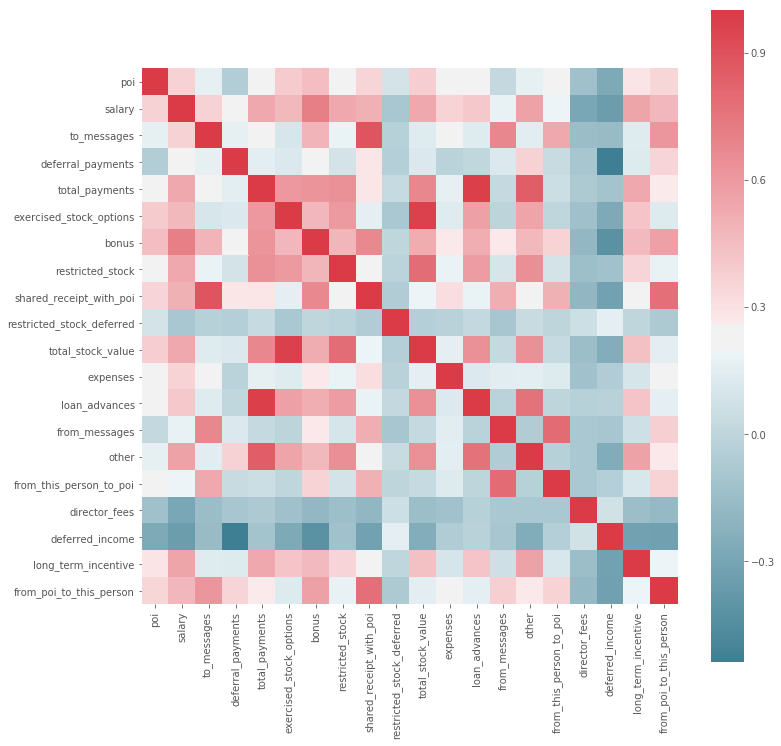

In [77]:
f, ax = plt.subplots(figsize=(12, 12))
corr = meta_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## K Best

In [78]:
X_df = meta_df.copy()
y_df = X_df['poi'].copy()
X_df.drop(['poi'], axis = 1, inplace = True)

In [79]:
kb = SelectKBest(k='all')
kb.fit(X_df, y_df)


SelectKBest(k='all', score_func=<function f_classif at 0x000000000C648A58>)

In [80]:
names = X_df.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns = ['Feature','f_score'])
ns_df_sorted = ns_df.sort_values(['f_score','Feature'], ascending =
[False, True])
print(ns_df_sorted)

                      Feature    f_score
5                       bonus  33.129423
4     exercised_stock_options  23.501172
9           total_stock_value  22.573309
0                      salary  20.021395
7     shared_receipt_with_poi  18.121245
18    from_poi_to_this_person  17.699080
17        long_term_incentive  11.540239
16            deferred_income  10.129927
3              total_payments   8.808366
6            restricted_stock   8.362250
10                   expenses   6.482924
11              loan_advances   6.480090
14    from_this_person_to_poi   6.148112
1                 to_messages   3.738645
13                      other   3.593790
15              director_fees   2.197621
8   restricted_stock_deferred   0.917976
2           deferral_payments   0.291675
12              from_messages   0.042280


[Text(0,0.5,'F_Score'), Text(0.5,0,'Feature')]

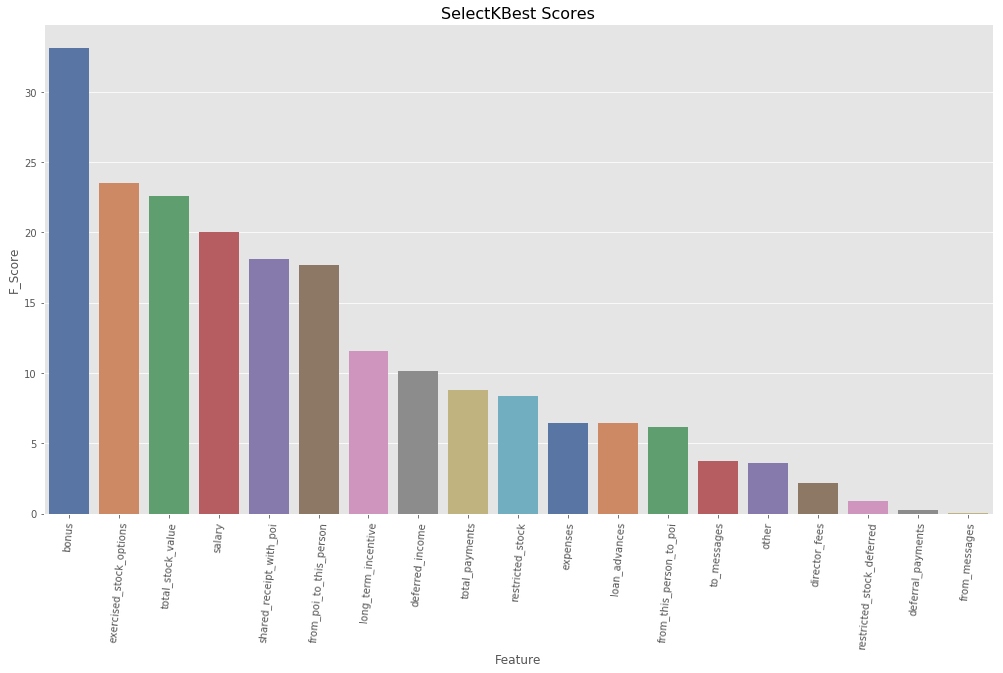

In [81]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(17,9))
ax1.set_title('SelectKBest Scores', fontdict = {'fontsize' : 16})

kg = sns.barplot(x =ns_df_sorted['Feature'], y = ns_df_sorted['f_score'], palette="deep", ax = ax1)
plt.setp(kg.get_xticklabels(), rotation=85)
ax1.set(xlabel='Feature', ylabel='F_Score')

# Meta Learners

In [82]:
meta_df.shape

(131, 20)

<a id='olsfinal'></a>
## StudentizedOLSClassifier

In [83]:
# ols vanilla
ols_m = StudentizedOLSClassifier(0.88) 
#model = Pipeline([('smt', smt),  ('ols', ols_m)])
model = ols_m
feat, dat = tester_prep(meta_df)
test_classifier(model, dat, feat)

StudentizedOLSClassifier(threshold=0.88)
	Accuracy: 0.85546	Precision: 0.52507	Recall: 0.63350	F1: 0.57421	F2: 0.60837
	Total predictions: 13000	True positives: 1267	False positives: 1146	False negatives:  733	True negatives: 9854



In [84]:
 # ols pipe
k = 19
ols_m = StudentizedOLSClassifier(0.9) 
#model = Pipeline([('fpr', SelectFpr()),  ('ols', ols_m)]) 
model = Pipeline([ ('kBest', SelectKBest( k = k)), ('ols', ols_m)])
#model = ols_m
feat, dat = tester_prep(meta_df)
test_classifier(model, dat, feat)

Pipeline(memory=None,
     steps=[('kBest', SelectKBest(k=19, score_func=<function f_classif at 0x000000000C648A58>)), ('ols', StudentizedOLSClassifier(threshold=0.9))])
	Accuracy: 0.85608	Precision: 0.52720	Recall: 0.62500	F1: 0.57195	F2: 0.60264
	Total predictions: 13000	True positives: 1250	False positives: 1121	False negatives:  750	True negatives: 9879



In [85]:
 # ols pipe smt
smt = SMOTE(kind = 'regular',k_neighbors = 7, random_state = SEED)

k = 23
ols_m = StudentizedOLSClassifier(1.1) 
#model = Pipeline([('fpr', SelectFpr()),  ('ols', ols_m)]) 
#model = Pipeline([ ('smt', smt), ('kBest', SelectKBest( k = k)), ('ols', ols_m)])
model = Pipeline([ ('smt', smt),  ('ols', ols_m)])
#model = ols_m
feat, dat = tester_prep(meta_df)
test_classifier(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=7, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('ols', StudentizedOLSClassifier(threshold=1.1))])
	Accuracy: 0.82946	Precision: 0.45783	Recall: 0.58900	F1: 0.51520	F2: 0.55708
	Total predictions: 13000	True positives: 1178	False positives: 1395	False negatives:  822	True negatives: 9605



## ADA FINAL

In [86]:
abc_cv = AdaBoostClassifier(random_state = SEED)

abc_grid = {'n_estimators' : [50, 75, 100, 150], 
            'learning_rate': [0.1, 0.2, 0.5]}

scoring = "recall"

gs_abc = GridSearchCV(abc_cv, param_grid=abc_grid, scoring=scoring, cv=5, n_jobs= 6, verbose = 1)

gs_abc.fit(X_df, y_df) 
results = gs_abc.cv_results_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    6.7s finished


In [87]:
print('Best kfold score: {}'.format(gs_abc.best_score_)) 
print('Best kfold parameters: {}'.format(gs_abc.best_params_))

Best kfold score: 0.345419847328
Best kfold parameters: {'n_estimators': 50, 'learning_rate': 0.1}


In [88]:
#old model better
abc_m = AdaBoostClassifier(n_estimators = 150,
                           learning_rate = 0.2,
                           random_state = SEED)

abc_m = AdaBoostClassifier()

In [89]:
# Fast TESTER with pipe
model = Pipeline([('smt', smt),  ('abc', abc_m)])
#model = abc_m
feat, dat = tester_prep(meta_df)
test_classifier_fast(model, dat, feat)

Pipeline(memory=None,
     steps=[('smt', SMOTE(k=None, k_neighbors=7, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=5678, ratio='auto', svm_estimator=None)), ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.81923	Precision: 0.41026	Recall: 0.40000	F1: 0.40506	F2: 0.40201
	Total predictions:  260	True positives:   16	False positives:   23	False negatives:   24	True negatives:  197



## LightGBM

In [90]:
lgb_cv = lgb.LGBMClassifier( objective   =  'binary' )

lgb_grid = {"learning_rate": [0.007, 0.01, 0.03],
                  "n_estimators": [ 750, 1000, 2000],
                  "boosting_type" : ['dart', 'GBDT'],
                  #"num_leaves": [31],
                  #"max_bin":[ 300],
                  #"rsm": [.05, 0.1, 0.15],
                  "max_depth": [-1],
                  "xgboost_dart_mode" : [True, False],
                  #"bootstrap": [True],
                  #"oob_score": [True],
                  #"n_estimators" :[500,1000,2000],
                  # "max_leaf_nodes" : np.rint(np.linspace(10, train_data.shape[0]/50, 10)).astype(int),
                  #"criterion": ["gini","entropy"],
                  'random_state' : [SEED]}



scoring = "recall"

gs_lgb = GridSearchCV(lgb_cv,
                     param_grid=lgb_grid,
                     scoring=scoring, cv=5, n_jobs= 6, verbose = 1)

gs_lgb.fit(X_df, y_df)
results = gs_lgb.cv_results_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:  1.7min finished


In [91]:
print('Best kfold score: {}'.format(gs_lgb.best_score_))
print('Best kfold parameters: {}'.format(gs_lgb.best_params_))

Best kfold score: 0.372773536896
Best kfold parameters: {'learning_rate': 0.01, 'xgboost_dart_mode': True, 'n_estimators': 750, 'random_state': 5678, 'max_depth': -1, 'boosting_type': 'GBDT'}


In [92]:
lgb_m = lgb.LGBMClassifier( learning_rate = 0.01, 
                           boosting_type = 'GBDT', 
                           n_estimators = 750, 
                           max_depth = -1, 
                           xgboost_dart_mode = True,
                           objective   =  'binary', 
                           random_state = SEED )

In [93]:
# Fast TESTER with pipe
k= 19
#model = Pipeline([('smt', smt),('kBest', SelectKBest( k = k)),  ('lgb', lgb_m)])
model = lgb_m
feat, dat = tester_prep(meta_df)
test_classifier_fast(model, dat, feat)

LGBMClassifier(boosting_type='GBDT', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=750, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=5678, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        xgboost_dart_mode=True)
	Accuracy: 0.83077	Precision: 0.40000	Recall: 0.20000	F1: 0.26667	F2: 0.22222
	Total predictions:  260	True positives:    8	False positives:   12	False negatives:   32	True negatives:  208

